In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random

tfk = tf.keras
tfkl = tf.keras.layers

In [17]:


inputBasePath = 'traffic_Data'
trainingFolder = 'DATA'
testingFolder = 'TEST'
# classes = pd.read_csv(os.path.join(inputBasePath,'labels.csv'))
classes = pd.read_csv('labels.csv')
classes_size = len(classes)
print("Total number of classes: ", classes_size)



Total number of classes:  58


In [15]:

# Function to load and preprocess images
def load_data(folder_path):
    images = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                if image_file.endswith(('.png')):
                    image_path = os.path.join(class_path, image_file)
                    # Load and preprocess image
                    img = Image.open(image_path)
                    img = img.resize((64, 64))  # Resize to match model input
                    img = img.convert('L')  # Convert to grayscale
                    img_array = np.array(img)
                    img_array = img_array / 255.0  # Normalize
                    images.append(img_array)
                    labels.append(int(class_folder))
    return np.array(images), np.array(labels)

In [18]:
# Load training data
print("Loading training data...")
X_train, y_train = load_data(os.path.join(inputBasePath, trainingFolder))
# Reshape images to include channel dimension
X_train = X_train.reshape(-1, 64, 64, 1)
# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, classes_size)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Loading training data...
Training data shape: (4170, 64, 64, 1)
Training labels shape: (4170, 58)


In [19]:
# Verifică distribuția claselor în datele de antrenament
y_train_labels = np.argmax(y_train, axis=1)
unique_labels, counts = np.unique(y_train_labels, return_counts=True)
print(f"Training - Classes found: {unique_labels[:10]}...")  # Primele 10
print(f"Training - Total samples: {len(y_train_labels)}")
print(f"Training - Classes size expected: {classes_size}")

Training - Classes found: [0 1 2 3 4 5 6 7 8 9]...
Training - Total samples: 4170
Training - Classes size expected: 58


In [20]:
# Split manual pentru train și validation
print("\nSplitting data for training and validation...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"Training split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val_split.shape}")


Splitting data for training and validation...
Training split shape: (3336, 64, 64, 1)
Validation split shape: (834, 64, 64, 1)


In [21]:
# Create the model
print("\nCreating model...")
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3),
                          strides=1, padding="same", activation="relu",
                          input_shape=(64,64,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(classes_size, activation="softmax"),
])


Creating model...


/home/glosper/anaconda3/envs/tf217/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 120)            │       491,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 58)             │         7,018 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,906 (1.91 MB)

 Trainable params: 499,906 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
print("\nTraining model...")
history = model.fit(X_train_split, y_train_split,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_val_split, y_val_split),
                    verbose=1)

print("\nTraining completed!")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")


Training model...
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1594 - loss: 3.5723 - val_accuracy: 0.4808 - val_loss: 2.2841
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5463 - loss: 1.9891 - val_accuracy: 0.7254 - val_loss: 1.1446
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7045 - loss: 1.1853 - val_accuracy: 0.8549 - val_loss: 0.7352
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8109 - loss: 0.7326 - val_accuracy: 0.8957 - val_loss: 0.4722
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8761 - loss: 0.4916 - val_accuracy: 0.9293 - val_loss: 0.3334
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9013 - loss: 0.3551 - val_accuracy: 0.9388 - val_loss: 0.2809
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9150 - loss: 0.3178 - val_accuracy: 0.9520 - val_loss: 0.2133
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9309 - loss: 0.2356

In [25]:
# Load and evaluate test data
print("\nLoading test data...")
testing_data = []
test_path = os.path.join(inputBasePath, testingFolder)


Loading test data...


In [10]:
# Evaluating the model on test data
testing_data = []
test_path = os.path.join(inputBasePath, testingFolder)

print(f"Loading test data from: {test_path}")

for test_image_file in os.listdir(test_path):
    if test_image_file.endswith(('.png')):  # Verifică extensia fișierului
        try:
            testImage = Image.open(os.path.join(test_path, test_image_file))
            testImage = testImage.convert("L")
            testImage = testImage.resize((64, 64))  # Aceeași dimensiune ca la training!
            testImage = np.array(testImage)
            testImage = testImage / 255.0  # Normalizare
            
            # Extrage eticheta din numele fișierului (presupunând că este în primele 2-3 caractere)
            # Ajustează această logică în funcție de formatul numelor de fișiere
            if len(test_image_file) >= 3:
                label = int(test_image_file[:3])  # sau test_image_file[1:3] dacă începe cu un caracter
            else:
                label = 0  # valoare default
                
            testing_data.append((testImage, label))
        except Exception as e:
            print(f"Error processing {test_image_file}: {e}")
            continue

if testing_data:
    testing_data_features, testing_data_labels = zip(*testing_data)
    testing_data_features = np.array(testing_data_features)
    testing_data_features = testing_data_features.reshape(-1, 64, 64, 1)  # Reshape pentru model
    testing_data_labels = np.array(testing_data_labels)
    
    # Convertire la format categorical pentru evaluare
    testing_data_labels_categorical = tf.keras.utils.to_categorical(testing_data_labels, classes_size)
    
    print(f"Test data shape: {testing_data_features.shape}")
    print(f"Test labels shape: {testing_data_labels_categorical.shape}")
    
    # Evaluarea modelului pe datele de test
    test_loss, test_accuracy = model.evaluate(testing_data_features, testing_data_labels_categorical)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    
    # Predicții
    predictions = model.predict(testing_data_features)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print("Sample predictions:")
    for i in range(min(5, len(predicted_classes))):
        print(f"True: {testing_data_labels[i]}, Predicted: {predicted_classes[i]}")
        
else:
    print("No test images found or processed successfully!")

Loading test data from: traffic_Data/TEST
Test data shape: (1994, 64, 64, 1)
Test labels shape: (1994, 58)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.5317 - loss: 8.1540
Test Loss: 7.6708478927612305
Test Accuracy: 0.541624903678894
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Sample predictions:
True: 26, Predicted: 54
True: 52, Predicted: 52
True: 13, Predicted: 5
True: 43, Predicted: 37
True: 55, Predicted: 55


Text(0.02, 0.98, '✓ Good Fit\nTrain: 0.976\nVal: 0.983')

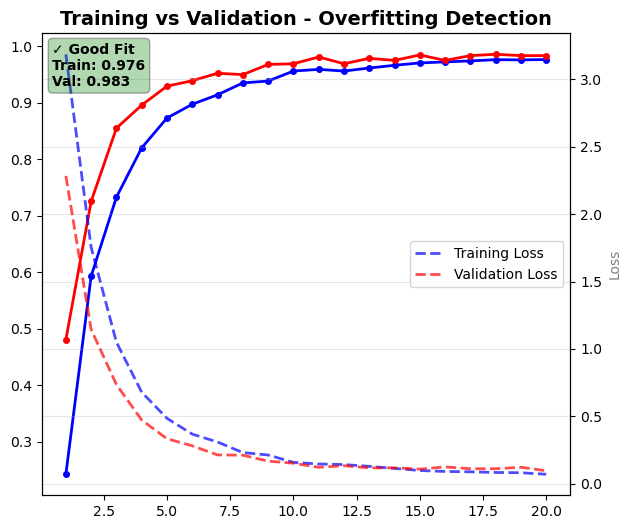

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. GRAFIC PENTRU OVERFITTING/UNDERFITTING
plt.figure(figsize=(15, 6))

# Subplot 1: Training vs Validation (pentru overfitting)
plt.subplot(1, 2, 1)
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot accuracy
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2, markersize=4)
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=4)

# Plot loss pe același grafic (axă secundară)
ax2 = plt.gca().twinx()
ax2.plot(epochs, history.history['loss'], 'b--', label='Training Loss', alpha=0.7, linewidth=2)
ax2.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss', alpha=0.7, linewidth=2)

plt.title('Training vs Validation - Overfitting Detection', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', color='black')
ax2.set_ylabel('Loss', color='gray')
plt.legend(loc='center left')
ax2.legend(loc='center right')
plt.grid(True, alpha=0.3)

# Adaugă text pentru interpretare
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
diff = abs(final_train_acc - final_val_acc)

if diff < 0.05:
    status = "✓ Good Fit"
    color = 'green'
elif final_train_acc > final_val_acc and diff > 0.1:
    status = "⚠ Overfitting"
    color = 'orange'
else:
    status = "⚠ Check Model"
    color = 'red'

plt.text(0.02, 0.98, f'{status}\nTrain: {final_train_acc:.3f}\nVal: {final_val_acc:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor=color, alpha=0.3),
         fontweight='bold')


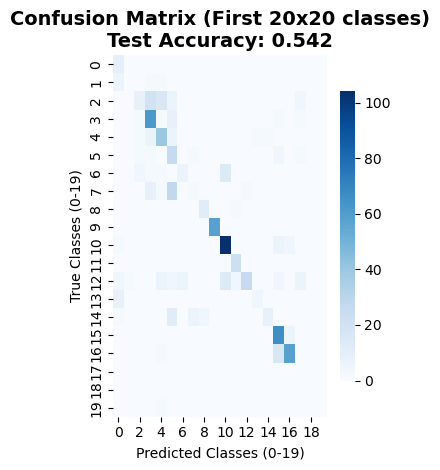

In [27]:
# 2. MATRICEA DE CONFUZIE
plt.subplot(1, 2, 2)

# Calculează matricea de confuzie pe datele de test
if 'testing_data_features' in locals() and 'testing_data_labels' in locals():
    # Predicții pe datele de test
    test_predictions = model.predict(testing_data_features, verbose=0)
    test_predicted_classes = np.argmax(test_predictions, axis=1)
    test_true_classes = testing_data_labels
    
    # Calculează matricea de confuzie
    cm = confusion_matrix(test_true_classes, test_predicted_classes)
    
    # Plotează matricea de confuzie
    # Pentru multe clase, folosim o matrice mai compactă
    if classes_size > 20:
        # Pentru multe clase, afișăm doar primele 20x20
        cm_display = cm[:20, :20]
        sns.heatmap(cm_display, annot=False, cmap='Blues', fmt='d', 
                   cbar_kws={'shrink': 0.8})
        plt.title(f'Confusion Matrix (First 20x20 classes)\nTest Accuracy: {test_accuracy:.3f}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Classes (0-19)')
        plt.ylabel('True Classes (0-19)')
    else:
        # Pentru puține clase, afișăm totul cu numere
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
                   cbar_kws={'shrink': 0.8})
        plt.title(f'Confusion Matrix\nTest Accuracy: {test_accuracy:.3f}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Classes')
        plt.ylabel('True Classes')
        
else:
    # Dacă nu avem date de test, folosim validation
    val_predictions = model.predict(X_val_split, verbose=0)
    val_predicted_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = np.argmax(y_val_split, axis=1)
    
    cm = confusion_matrix(val_true_classes, val_predicted_classes)
    
    if classes_size > 20:
        cm_display = cm[:20, :20]
        sns.heatmap(cm_display, annot=False, cmap='Blues', fmt='d',
                   cbar_kws={'shrink': 0.8})
        plt.title(f'Confusion Matrix - Validation (First 20x20)\nVal Accuracy: {final_val_acc:.3f}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Classes (0-19)')
        plt.ylabel('True Classes (0-19)')
    else:
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                   cbar_kws={'shrink': 0.8})
        plt.title(f'Confusion Matrix - Validation\nVal Accuracy: {final_val_acc:.3f}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Classes')
        plt.ylabel('True Classes')

plt.tight_layout()
plt.savefig('model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()